In [1]:
import os
import datetime
import numpy as np
import pandas as pd
import colorcet as cc
import seaborn as sns
import rasterio as rio
import geopandas as gp

import fiona 
import rasterio
import rasterio.mask

import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
import matplotlib.dates as mdates

from rasterio.mask import mask
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

from matplotlib.lines import Line2D      
from matplotlib.cm import get_cmap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tqdm import tqdm

import matplotlib.pyplot as plt
from collections import OrderedDict 

from osgeo import gdal, osr, ogr
from tqdm import tqdm

In [2]:
# Helpers

def plot_basemaps(image, shp, title = None, cmap = 'viridis', ax = None, latlabels = True, lonlabels = True, vmax = None):
    imextent = gp.read_file(shp).set_crs("EPSG:4326").to_crs(4326).total_bounds
    shape_feature = ShapelyFeature(Reader("../shape/sierra_catchments.shp").geometries(),
                        ccrs.PlateCarree(), edgecolor='white', facecolor = 'none')

    minx, miny, maxx, maxy = imextent
    lllon, lllat = minx, miny
    urlon, urlat = maxx, maxy

    # Create a Stamen Terrain instance.
    stamen_terrain = cimgt.Stamen('terrain-background')

    # Create a GeoAxes in the tile's projection.
    gl = ax.gridlines(draw_labels=True)
    gl.top_labels= False
    gl.right_labels = False
    if not latlabels:
        gl.left_labels = False
    if not lonlabels:
        gl.bottom_labels = False
    
    gl.xlocator = mticker.FixedLocator([-122,-121,-120,-119])
    gl.ylocator = mticker.FixedLocator(np.linspace(0,90,91))
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 8, 'color': 'gray', 'rotation': 45}
    gl.ylabel_style = {'size': 9, 'color': 'gray'}

    # Limit the extent of the map to a small longitude/latitude range.
    ax.set_extent([lllon, urlon, lllat, urlat])

    # Add the Stamen data at zoom level 8.
    ax.add_image(stamen_terrain, 8)
    
    im = ax.imshow(image,
        cmap=cmap, zorder=1, vmin = 0, vmax = vmax,
        origin="upper", alpha = 0.8,
        extent=(lllon, urlon, lllat, urlat),
        transform=ccrs.PlateCarree(),
    )

    # Add shapefile outline
    ax.add_feature(shape_feature, zorder = 2)
    
    # Set the title
    ax.set_title("{}".format(title), size = 12)
    
#     cbar = plt.colorbar(mappable=im,orientation='vertical', fraction=0.05, pad = 0.0125, ax = ax)

    return im

In [3]:
# read files setup dirs 
gdf = gp.read_file("../shape/sierra_catchments.shp")

stids = list(gdf['stid'].values)

# Define outdirs
results_dir = "../results/flow_dist/"
outdir = os.path.join(results_dir,"merged")
clipdir = os.path.join(results_dir,"clipped")

if not os.path.exists(outdir):
    os.mkdir(outdir)
    
if not os.path.exists(clipdir):
    os.mkdir(clipdir)

# Clip by watershed into the clipped dir
for stn_id in stids[:]:
    
    print("****" * 15)
    print("PROCESSING : {}".format(stn_id))
    print("****" * 15)

    # get shapefile 
    catch_shp = os.path.abspath("../shape/{}.shp".format(stn_id))
    
    # Get files matching the wshed 
    wshed_files = [os.path.join(results_dir,x) for x in os.listdir(results_dir) if stn_id in x]
    wshed_files = [os.path.abspath(x) for x in wshed_files]
    
    for fn in wshed_files:
        varfn = os.path.split(fn)[1]
        outfn = os.path.join(clipdir,varfn) 
        if not os.path.exists(outfn):
            cmd = '''gdalwarp -dstnodata -999 -cutline {} -crop_to_cutline {} {}'''.format(catch_shp, fn, outfn)
            os.system(cmd)
    print("DONE ---")



************************************************************
PROCESSING : SJF
************************************************************
DONE ---
************************************************************
PROCESSING : TLG
************************************************************
DONE ---
************************************************************
PROCESSING : ISB
************************************************************
DONE ---
************************************************************
PROCESSING : NAT
************************************************************
DONE ---
************************************************************
PROCESSING : MHB
************************************************************
DONE ---
************************************************************
PROCESSING : NML
************************************************************
DONE ---
************************************************************
PROCESSING : ORO
**********************************

In [4]:
# Merge files 

dist_files = [os.path.join(clipdir,x) for x in os.listdir(clipdir) if x.endswith(".tif")]

# merge and write 
dist_merged_fn = os.path.join(outdir,"dist.tiff")
if not os.path.exists(dist_merged_fn):
    g_prcp = gdal.Warp(dist_merged_fn, dist_files, format="GTiff")
    g_prcp = None # Close file
    print("WROTE {}".format(dist_merged_fn))

In [5]:
# Resample to correct resolution 

# open reference file and get resolution
referenceFile = "/Users/aakashahamed/Desktop/SpatioTemporal/results/BF_src/merged/prcp.tiff"
reference = gdal.Open(referenceFile, 0)  # this opens the file in only reading mode
referenceTrans = reference.GetGeoTransform()
x_res = referenceTrans[1]
y_res = -referenceTrans[5]  # make sure this value is positive

# specify input and output filenames
inputFile = "/Users/aakashahamed/Desktop/SpatioTemporal/results/flow_dist/merged/dist.tiff"
outputFile = "/Users/aakashahamed/Desktop/SpatioTemporal/results/flow_dist/merged/dist_res.tiff"

# call gdal Warp
kwargs = {"format": "GTiff", "xRes": x_res, "yRes": y_res}
ds = gdal.Warp(outputFile, inputFile, **kwargs)

ds = None

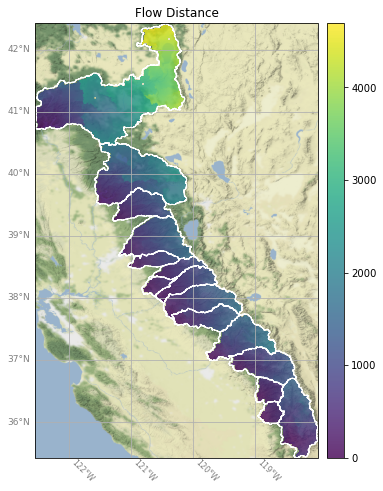

In [6]:
src = rio.open("../results/flow_dist/merged/dist_res.tiff")
arr = src.read(1)
arr[arr==src.nodata] = np.nan

fig, axes = plt.subplots(nrows=1, ncols=1,figsize = (12,8), subplot_kw={'projection': ccrs.PlateCarree()})
im = plot_basemaps(arr, "../shape/sierra_catchments.shp", "Flow Distance", cmap = 'viridis', ax = axes, latlabels = True, lonlabels = True)
fig.subplots_adjust(wspace=0.02,hspace =0.00)
cax = fig.add_axes([axes.get_position().x1+0.01,axes.get_position().y0,0.02,axes.get_position().y1-axes.get_position().y0])
fig.colorbar(mappable = im, orientation='vertical', cax = cax,ax = axes)

plt.show()


In [7]:
psrc = rio.open("../results/BF_src/merged/smlt.tiff")
parr = psrc.read(1)
parr[parr==psrc.nodata] = np.nan
parr[parr<=0] = np.nan

In [8]:
parr.shape, arr.shape

((866, 564), (866, 564))

In [9]:
# Final results dict 
dist_res_sheds = []

cor_dir = "../results/BF_src/merged"
dist_dir = "../results/flow_dist/merged/"


for stid in tqdm(stids):
    
    # Read each contour interval shape
    with fiona.open("../shape/{}.shp".format(stid), "r") as shapefile:
        shape = [feature["geometry"] for feature in shapefile]
    
    for vartype in ['smlt','prcp'][:]:
        cor_fn = os.path.join(cor_dir,vartype+".tiff")
        dist_fn = os.path.join(dist_dir,"dist_res.tiff")
        
        with rasterio.open(cor_fn) as src:
            out_image, out_transform = rasterio.mask.mask(src, shape, crop=True)
            outim = out_image.reshape(out_image.shape[1],out_image.shape[2])
            outim[outim==src.nodata]=np.nan #mask nodata vals
            outim[outim<=0] = np.nan
            cor_vals = outim.flatten()

        with rasterio.open(dist_fn) as src:
            out_image, out_transform = rasterio.mask.mask(src, shape, crop=True)
            outim = out_image.reshape(out_image.shape[1],out_image.shape[2])
            outim[outim==src.nodata]=np.nan #mask nodata vals
            outim[outim<=0] = np.nan
            dist_vals= outim.flatten()

            # Concat the stats we just extracted 
            tdf = pd.DataFrame([dist_vals,cor_vals]).T
            tdf.columns=['dist','cor']
            tdf['id'] = [stid for x in range(len(tdf))]
            tdf['vartype'] = [vartype for x in range(len(tdf))]
            dist_res_sheds.append(tdf)


100%|██████████| 15/15 [00:22<00:00,  1.47s/it]


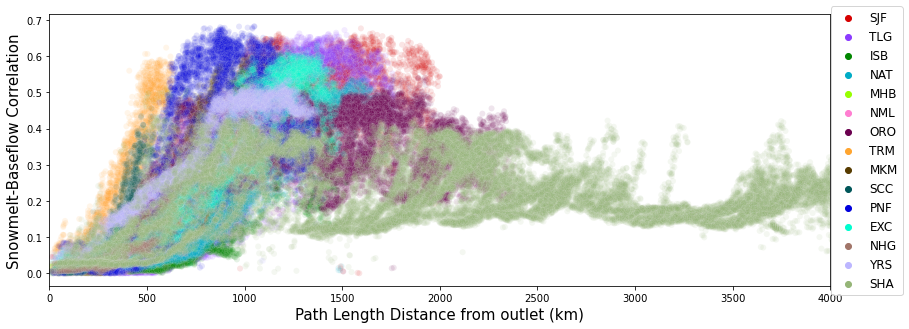

In [10]:
dist_df = pd.concat(dist_res_sheds, axis = 0).dropna()
smdf = dist_df[dist_df['vartype']=='smlt']

palette = sns.color_palette(cc.glasbey, n_colors=len(stids))

fig, ax = plt.subplots(figsize=(14,5))
ax = sns.scatterplot(x='dist',y='cor',hue = 'id',data = smdf,legend='full',
                     palette = palette, alpha = 0.1)
ax.set_xlabel("Path Length Distance from outlet (km)", size = 15)
ax.set_ylabel("Snowmelt-Baseflow Correlation", size = 15)
ax.set_xlim([0,4000])
ax.legend(loc='upper right', bbox_to_anchor = (1.1,1.05), fontsize = 12)

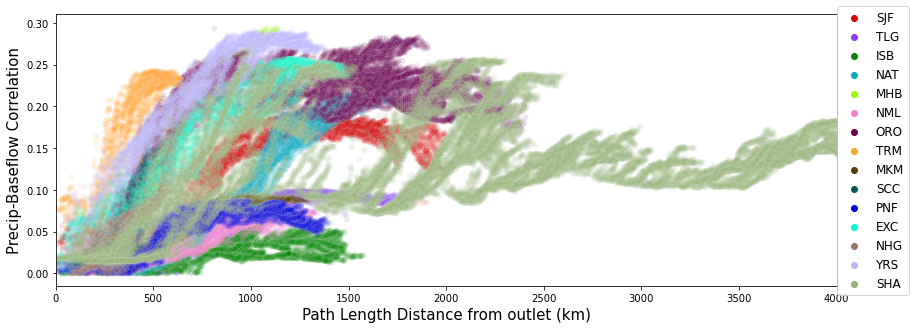

In [11]:
dist_df = pd.concat(dist_res_sheds, axis = 0).dropna()
prdf = dist_df[dist_df['vartype']=='prcp']

palette = sns.color_palette(cc.glasbey, n_colors=len(stids))

fig, ax = plt.subplots(figsize=(14,5))
ax = sns.scatterplot(x='dist',y='cor',hue = 'id',data = prdf,legend='full',
                     palette = palette, alpha = 0.1)
ax.set_xlabel("Path Length Distance from outlet (km)", size = 15)
ax.set_ylabel("Precip-Baseflow Correlation", size = 15)
ax.set_xlim([0,4000])
ax.legend(loc='upper right', bbox_to_anchor = (1.1,1.05), fontsize = 12)